In [1]:
import pandas as pd
import re
import spacy
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora import Dictionary
from gensim import corpora
from gensim.models import LdaModel
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from collections import defaultdict
from wordcloud import WordCloud
from nltk import FreqDist
import seaborn as sns

# Carga información y preprocesamiento de datos

In [2]:
columns = ['chanel_name', 'text', 'embedding']
df = pd.read_csv('dataset_videos_youtube_embeddings.csv', delimiter=';', usecols=columns)

In [3]:
# Cargar el modelo de español de spaCy
nlp = spacy.load('es_core_news_sm')

In [4]:
# Stopwords personalizadas
custom_stopwords = set(nlp.Defaults.stop_words).union(set(['eh']))

In [5]:
def preprocess_text(text):
    # Convertir a minúsculas
    text = text.lower()
    
    # Eliminar puntuación y símbolos
    text = re.sub(r'[^\w\s]', '', text)
    
    # Tokenización y lematización con spaCy
    doc = nlp(text)
    lemmatized_tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct and token.text not in custom_stopwords]
    
    return lemmatized_tokens

In [6]:
# Aplicar preprocesamiento
df['processed_text'] = df['text'].apply(preprocess_text)

In [7]:
df.head()

,chanel_name,text,embedding,processed_text
0,ARENA ALFA,analisis tecnico bancolombia $cib 09 sep 14. m...,"[-0.0563782938, -0.0187230315, 0.0157550648, -...","[analisis, tecnico, bancolombiar, cib, 09, sep..."
1,ARENA ALFA,video analisis tecnico avianca 05 sept 14. bue...,"[-0.0464686491, -0.0173830092, 0.018592719, -0...","[video, analisis, tecnico, avianco, 05, sept, ..."
2,ARENA ALFA,video analisis canacol 04 sept 14. señores muy...,"[-0.0531722419, -0.0207217354, 0.0138077186, -...","[video, analisis, canacol, 04, sept, 14, señor..."
3,ARENA ALFA,analisis tecnico ecopetrol 03-sept-14. señores...,"[-0.0265590865, -0.0268863291, -0.00136133307,...","[analisis, tecnico, ecopetrol, 03sept14, señor..."
4,ARENA ALFA,vocabulario bursatil - como hablan los traders...,"[-0.0419106558, -0.0179280099, 0.0285170674, -...","[vocabulario, bursatil, , trader, 1, saludo, ..."


# Wordcloud

In [9]:
texts_by_channel = df.groupby('chanel_name')['processed_text'].apply(lambda x: ' '.join([' '.join(text) for text in x]))

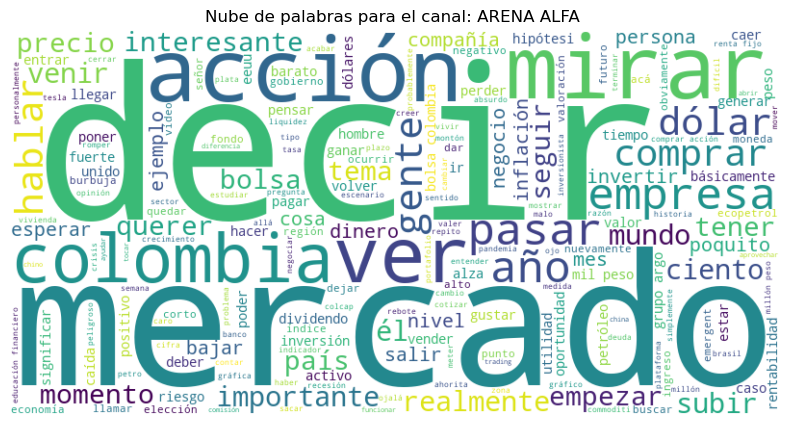

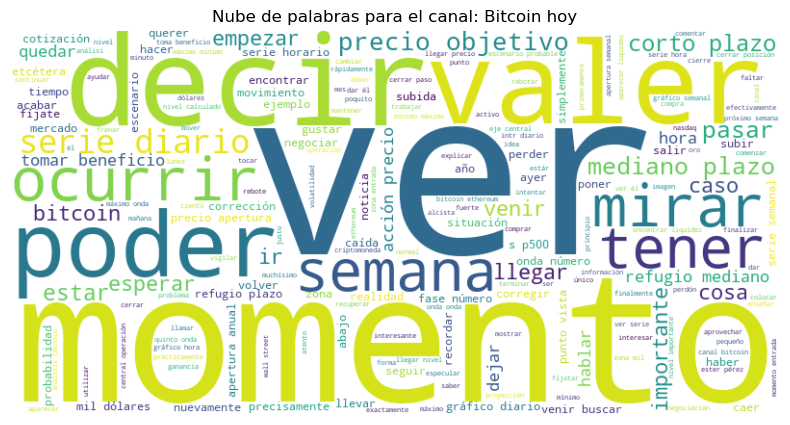

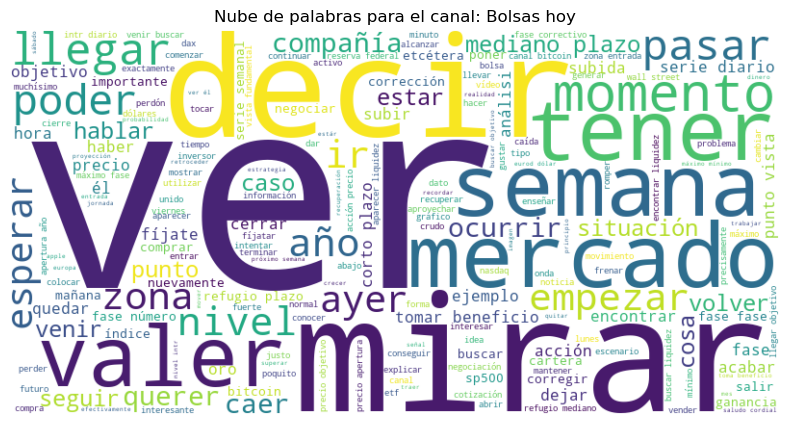

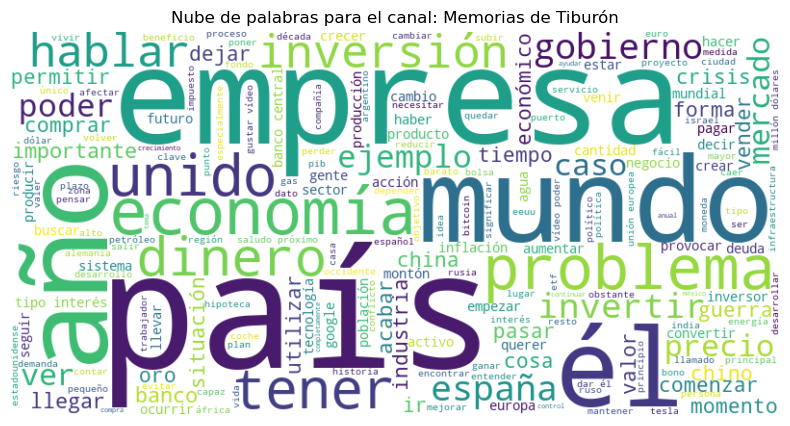

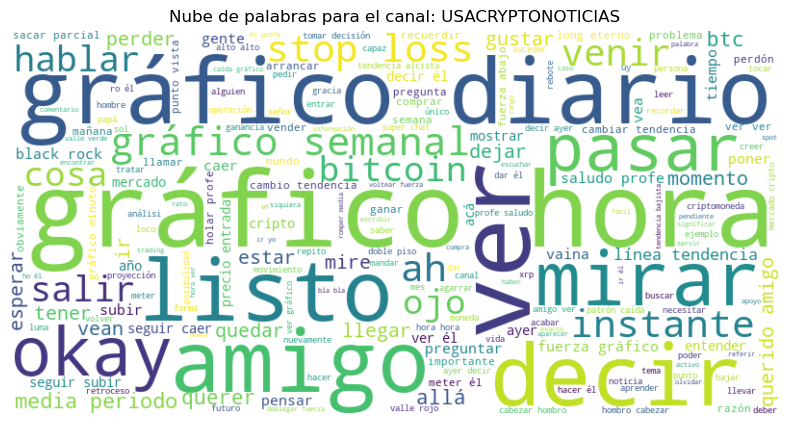

In [10]:
for channel, text in texts_by_channel.items():
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Nube de palabras para el canal: {channel}')
    plt.show()

# Reducción de dimensionalidad

In [19]:
# Convertir cada cadena en una lista de números
df['embedding'] = df['embedding'].apply(eval)

# Convertir embeddings a una matriz numpy
embeddings = np.array(df['embedding'].tolist())

In [20]:
# Ajustar PCA al conjunto de datos para obtener todas las componentes
pca = PCA()
pca.fit(embeddings)

PCA()

In [21]:
# Varianza explicada acumulada
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

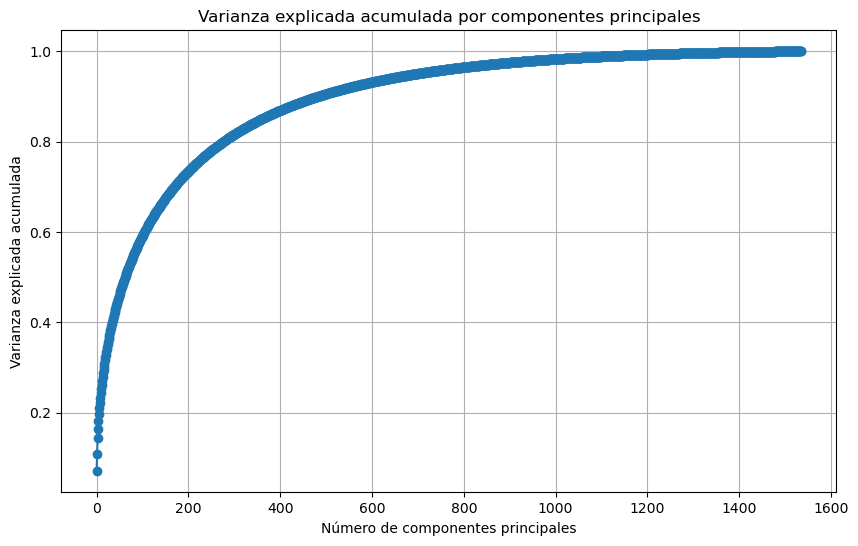

In [22]:
# Graficar la varianza explicada acumulada
plt.figure(figsize=(10, 6))
plt.plot(cumulative_variance, marker='o')
plt.xlabel('Número de componentes principales')
plt.ylabel('Varianza explicada acumulada')
plt.title('Varianza explicada acumulada por componentes principales')
plt.grid(True)
plt.show()

In [23]:
# Determinar el número de componentes para retener el 95% de la varianza
threshold = 0.95
num_components = np.argmax(cumulative_variance >= threshold) + 1

print(f"Número de componentes que explican al menos el {threshold*100}% de la varianza: {num_components}")

Número de componentes que explican al menos el 95.0% de la varianza: 697


In [24]:
# Reducción de dimensionalidad con PCA usando el número de componentes seleccionado
pca = PCA(n_components=num_components)
embeddings_pca = pca.fit_transform(embeddings)

In [25]:
# Visualización con t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=0)
embeddings_tsne = tsne.fit_transform(embeddings_pca)

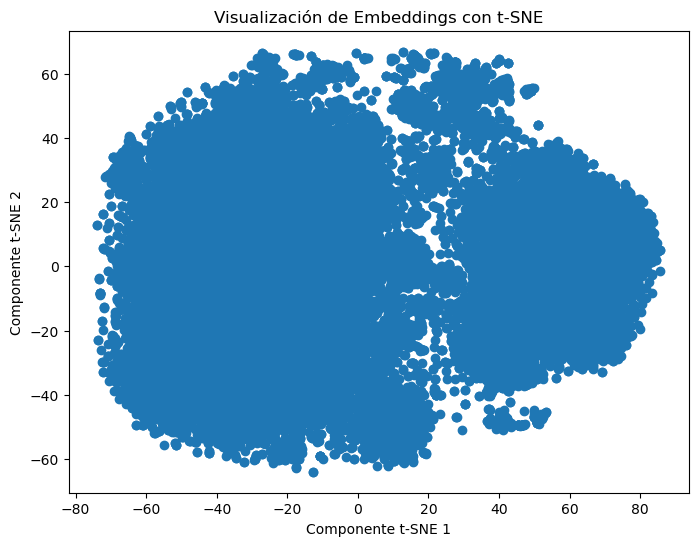

In [26]:
# Visualización en 2D
plt.figure(figsize=(8, 6))
plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1])
plt.xlabel('Componente t-SNE 1')
plt.ylabel('Componente t-SNE 2')
plt.title('Visualización de Embeddings con t-SNE')
plt.show()

# Modelado de tópicos con LDA Sklearn

## Sin ajuste de parámetros

### Cálculo de coherencias

In [41]:
# Crear la matriz término-documento
vectorizer = CountVectorizer(tokenizer=lambda x: x, lowercase=False)
X = vectorizer.fit_transform(df['processed_text'])

In [14]:
feature_names = vectorizer.get_feature_names_out()

In [15]:
# Convertir documentos a listas de palabras
documents = df['processed_text']

# Crear el diccionario y el corpus
dictionary = Dictionary(documents)
corpus = [dictionary.doc2bow(doc) for doc in documents]

In [16]:
# Función para calcular la coherencia
def compute_coherence(dictionary, corpus, texts, limit, start=2, step=1):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LatentDirichletAllocation(n_components=num_topics, random_state=0)
        model.fit(X)
        model_list.append(model)
        topics = [[feature_names[i] for i in topic.argsort()[:-11:-1]] for topic in model.components_]
        cm = CoherenceModel(topics=topics, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(cm.get_coherence())
    return model_list, coherence_values

In [17]:
# Calcular coherencia para diferentes valores de K
start, limit, step = 2, 10, 1
model_list, coherence_values = compute_coherence(dictionary=dictionary, corpus=corpus, texts=documents, start=start, limit=limit, step=step)

In [18]:
# Mostrar coherencia para cada K
for m, cv in zip(range(start, limit, step), coherence_values):
    print(f"Num Tópicos = {m}  tiene Coherencia de  {cv:.4f}")

Num Tópicos = 2  tiene Coherencia de  0.4881
Num Tópicos = 3  tiene Coherencia de  0.4983
Num Tópicos = 4  tiene Coherencia de  0.4877
Num Tópicos = 5  tiene Coherencia de  0.4724
Num Tópicos = 6  tiene Coherencia de  0.5006
Num Tópicos = 7  tiene Coherencia de  0.5058
Num Tópicos = 8  tiene Coherencia de  0.5113
Num Tópicos = 9  tiene Coherencia de  0.4955


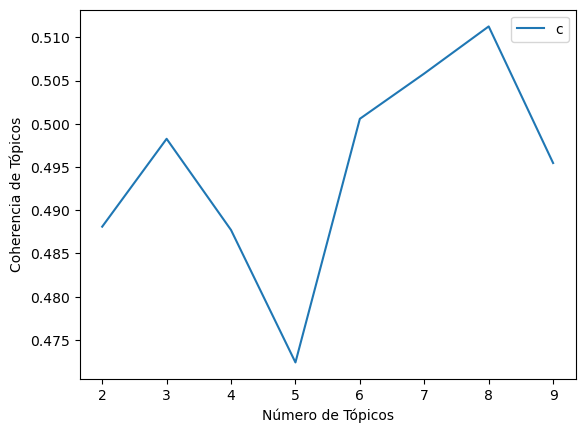

In [19]:
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Número de Tópicos")
plt.ylabel("Coherencia de Tópicos")
plt.legend("coherencia de tópicos")
plt.show()

### Ajuste de modelo LDA Sklearn

In [20]:
# Ajustar el modelo LDA con K=8
K = 8
lda_sklearn_model = LatentDirichletAllocation(n_components=K, random_state=0)
lda_sklearn_model.fit(X)

LatentDirichletAllocation(n_components=8, random_state=0)

In [21]:
# Ver los tópicos
for i, topic in enumerate(lda_sklearn_model.components_):
    print(f"Tópico {i}:")
    print(" ".join([feature_names[i] for i in topic.argsort()[:-11:-1]]))

Tópico 0:
amigo ver hora stop minuto operar decir entrada 15 gráfico
Tópico 1:
bitcoin comprar decir mercado vender año dinero etf black rock
Tópico 2:
acción mercado mirar año decir colombia subir bolsa dólar ver
Tópico 3:
profe ver saludo amigo gracias like btc listo bitcoin  
Tópico 4:
ver nivel precio zona objetivo momento bitcoin semana plazo fase
Tópico 5:
gráfico ver bitcoin hora media diario decir okay 4 pasar
Tópico 6:
ver amigo gráfico decir hora profe abajo esperar fuerza 4
Tópico 7:
metaverso moneda atom coin mundo criptomoneda información gafa llamar maná


### Clusterización

In [32]:
# Aplicar K-means a los embeddings reducidos por t-SNE
kmeans = KMeans(n_clusters=8, n_init=10, random_state=0)
clusters = kmeans.fit_predict(embeddings_tsne)

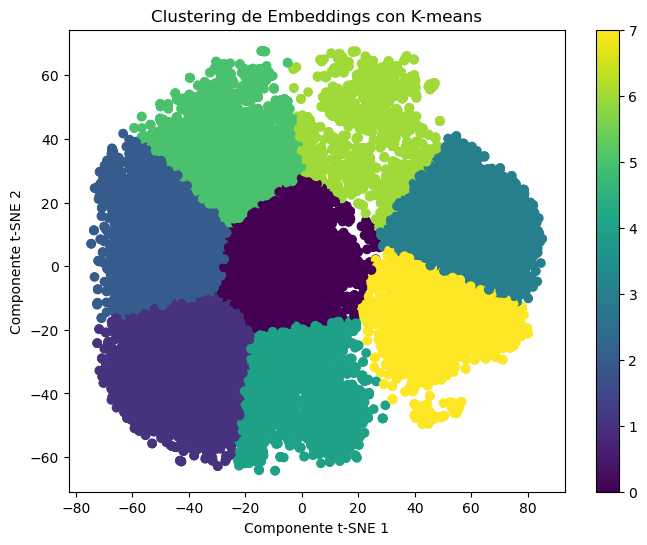

In [33]:
# Visualización de clusters
plt.figure(figsize=(8, 6))
plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], c=clusters, cmap='viridis')
plt.xlabel('Componente t-SNE 1')
plt.ylabel('Componente t-SNE 2')
plt.title('Clustering de Embeddings con K-means')
plt.colorbar()
plt.show()

### Análisis de tópicos

In [43]:
# Obtener las distribuciones de tópicos para cada documento
topic_distributions = lda_sklearn_model.transform(X)

# Extraer el tópico dominante para cada documento y encontrar el tópico con la mayor probabilidad
lda_topics = []
for doc in topic_distributions:
    dominant_topic = doc.argmax()
    lda_topics.append(dominant_topic)

In [45]:
# Añadir resultados de LDA y clustering al DataFrame original
df['lda_topic'] = lda_topics
df['cluster'] = clusters

In [47]:
# Evaluar la coherencia de tópicos dentro de cada cluster
topic_cluster_coherence = df.groupby(['cluster', 'lda_topic']).size().unstack(fill_value=0)
topic_cluster_coherence

lda_topic,0,1,2,3,4,5,6,7
cluster,,,,,,,,
0,308,495,19,655,57,798,1080,20
1,928,41,1,345,1,1122,1559,2
2,770,65,0,1261,1,213,1178,1
3,0,3,7,0,3599,0,0,0
4,428,86,1,187,13,1441,687,2
5,281,652,42,1590,21,69,364,3
6,20,713,1009,48,346,71,78,3
7,1,25,4,1,3193,8,1,1


In [48]:
# Basado en la tabla de distribución, definir los tópicos predominantes por clúster
top_topics_per_cluster = {0: 6, 1: 6, 2: 3, 3: 4, 4: 5, 5: 3, 6: 2, 7: 4}

In [49]:
# Extraer las palabras clave para cada tópico predominante
final_topics = {}
for cluster, topic_idx in top_topics_per_cluster.items():
    top_features_ind = lda_sklearn_model.components_[topic_idx].argsort()[:-11:-1]
    top_features = [feature_names[i] for i in top_features_ind]
    final_topics[cluster] = top_features

In [50]:
# Mostrar los tópicos finales
for cluster, words in final_topics.items():
    print(f"Tópico principal para el clúster {cluster}: {', '.join(words)}")

Tópico principal para el clúster 0: ver, amigo, gráfico, decir, hora, profe, abajo, esperar, fuerza, 4
Tópico principal para el clúster 1: ver, amigo, gráfico, decir, hora, profe, abajo, esperar, fuerza, 4
Tópico principal para el clúster 2: profe, ver, saludo, amigo, gracias, like, btc, listo, bitcoin,  
Tópico principal para el clúster 3: ver, nivel, precio, zona, objetivo, momento, bitcoin, semana, plazo, fase
Tópico principal para el clúster 4: gráfico, ver, bitcoin, hora, media, diario, decir, okay, 4, pasar
Tópico principal para el clúster 5: profe, ver, saludo, amigo, gracias, like, btc, listo, bitcoin,  
Tópico principal para el clúster 6: acción, mercado, mirar, año, decir, colombia, subir, bolsa, dólar, ver
Tópico principal para el clúster 7: ver, nivel, precio, zona, objetivo, momento, bitcoin, semana, plazo, fase


## Con ajuste de parámetros

### Cálculo de coherencias

In [52]:
# Crear la matriz término-documento
vectorizer = CountVectorizer(tokenizer=lambda x: x, lowercase=False)
X = vectorizer.fit_transform(df['processed_text'])

In [53]:
feature_names = vectorizer.get_feature_names_out()

In [54]:
# Convertir documentos a listas de palabras
documents = df['processed_text']

# Crear el diccionario y el corpus
dictionary = Dictionary(documents)
corpus = [dictionary.doc2bow(doc) for doc in documents]

In [55]:
# Función para calcular la coherencia
def compute_coherence(dictionary, corpus, texts, limit, start=2, step=1):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LatentDirichletAllocation(n_components=num_topics, max_iter=10, learning_method='online', learning_decay=0.7, random_state=0)
        model.fit(X)
        model_list.append(model)
        topics = [[feature_names[i] for i in topic.argsort()[:-11:-1]] for topic in model.components_]
        cm = CoherenceModel(topics=topics, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(cm.get_coherence())
    return model_list, coherence_values

In [56]:
# Calcular coherencia para diferentes valores de K
start, limit, step = 2, 10, 1
model_list, coherence_values = compute_coherence(dictionary=dictionary, corpus=corpus, texts=documents, start=start, limit=limit, step=step)

In [57]:
# Mostrar coherencia para cada K
for m, cv in zip(range(start, limit, step), coherence_values):
    print(f"Num Tópicos = {m}  tiene Coherencia de  {cv:.4f}")

Num Tópicos = 2  tiene Coherencia de  0.4996
Num Tópicos = 3  tiene Coherencia de  0.4935
Num Tópicos = 4  tiene Coherencia de  0.4840
Num Tópicos = 5  tiene Coherencia de  0.5389
Num Tópicos = 6  tiene Coherencia de  0.5364
Num Tópicos = 7  tiene Coherencia de  0.5519
Num Tópicos = 8  tiene Coherencia de  0.5552
Num Tópicos = 9  tiene Coherencia de  0.5418


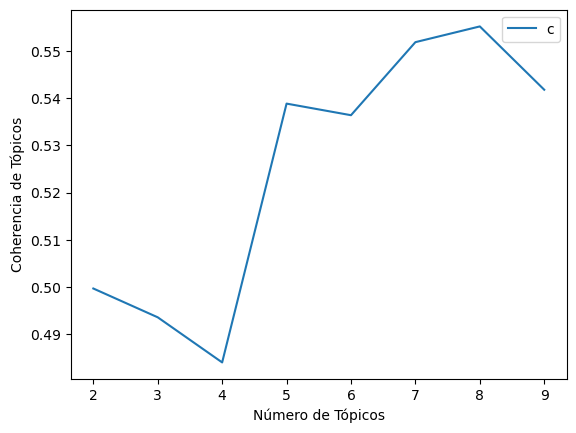

In [58]:
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Número de Tópicos")
plt.ylabel("Coherencia de Tópicos")
plt.legend("coherencia de tópicos")
plt.show()

### Ajuste de modelo LDA Sklearn

In [59]:
# Ajustar el modelo LDA con K=8
K = 8
lda_sklearn_model = LatentDirichletAllocation(n_components=K, max_iter=10, learning_method='online', learning_decay=0.7, random_state=0)
lda_sklearn_model.fit(X)

LatentDirichletAllocation(learning_method='online', n_components=8,
                          random_state=0)

In [60]:
# Ver los tópicos
for i, topic in enumerate(lda_sklearn_model.components_):
    print(f"Tópico {i}:")
    print(" ".join([feature_names[i] for i in topic.argsort()[:-11:-1]]))

Tópico 0:
gráfico hora ver 4 diario fuerza media abajo amigo bitcoin
Tópico 1:
acción mercado mirar año decir colombia subir bolsa dólar comprar
Tópico 2:
ver nivel precio objetivo zona fase plazo semana momento máximo
Tópico 3:
profe saludo like gracias btc ver greg gracia hola amigo
Tópico 4:
país dinero mundo invertir empresa moneda inversión gobierno año economía
Tópico 5:
bitcoin mercado etf noticia dato mes año unidos etfs oro
Tópico 6:
decir ver amigo comprar bitcoin   querer ganar esperar mercado
Tópico 7:
ver okay profe amigo pedir josé subir short xrp criptomoneda


### Clusterización

In [61]:
# Aplicar K-means a los embeddings reducidos por t-SNE
kmeans = KMeans(n_clusters=8, n_init=10, random_state=0)
clusters = kmeans.fit_predict(embeddings_tsne)

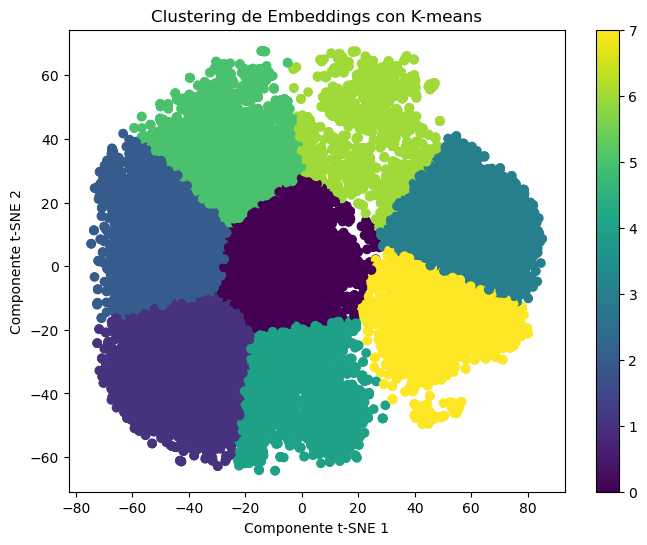

In [62]:
# Visualización de clusters
plt.figure(figsize=(8, 6))
plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], c=clusters, cmap='viridis')
plt.xlabel('Componente t-SNE 1')
plt.ylabel('Componente t-SNE 2')
plt.title('Clustering de Embeddings con K-means')
plt.colorbar()
plt.show()

### Análisis de tópicos

In [63]:
# Obtener las distribuciones de tópicos para cada documento
topic_distributions = lda_sklearn_model.transform(X)

# Extraer el tópico dominante para cada documento y encontrar el tópico con la mayor probabilidad
lda_topics = []
for doc in topic_distributions:
    dominant_topic = doc.argmax()
    lda_topics.append(dominant_topic)

In [64]:
# Añadir resultados de LDA y clustering al DataFrame original
df['lda_topic'] = lda_topics
df['cluster'] = clusters

In [65]:
# Evaluar la coherencia de tópicos dentro de cada cluster
topic_cluster_coherence = df.groupby(['cluster', 'lda_topic']).size().unstack(fill_value=0)
topic_cluster_coherence

lda_topic,0,1,2,3,4,5,6,7
cluster,,,,,,,,
0,591,6,55,17,9,8,2615,131
1,2128,0,1,10,0,0,1789,71
2,435,0,1,73,0,0,2889,91
3,0,5,3588,0,0,13,3,0
4,1595,0,13,10,0,7,1184,36
5,54,25,26,141,36,4,2716,20
6,38,893,337,1,404,103,511,1
7,7,3,3176,0,1,35,12,0


In [66]:
# Basado en la tabla de distribución, definir los tópicos predominantes por clúster
top_topics_per_cluster = {0: 6, 1: 0, 2: 6, 3: 2, 4: 0, 5: 6, 6: 1, 7: 2}

In [67]:
# Extraer las palabras clave para cada tópico predominante
final_topics = {}
for cluster, topic_idx in top_topics_per_cluster.items():
    top_features_ind = lda_sklearn_model.components_[topic_idx].argsort()[:-11:-1]
    top_features = [feature_names[i] for i in top_features_ind]
    final_topics[cluster] = top_features

In [68]:
# Mostrar los tópicos finales
for cluster, words in final_topics.items():
    print(f"Tópico principal para el clúster {cluster}: {', '.join(words)}")

Tópico principal para el clúster 0: decir, ver, amigo, comprar, bitcoin,  , querer, ganar, esperar, mercado
Tópico principal para el clúster 1: gráfico, hora, ver, 4, diario, fuerza, media, abajo, amigo, bitcoin
Tópico principal para el clúster 2: decir, ver, amigo, comprar, bitcoin,  , querer, ganar, esperar, mercado
Tópico principal para el clúster 3: ver, nivel, precio, objetivo, zona, fase, plazo, semana, momento, máximo
Tópico principal para el clúster 4: gráfico, hora, ver, 4, diario, fuerza, media, abajo, amigo, bitcoin
Tópico principal para el clúster 5: decir, ver, amigo, comprar, bitcoin,  , querer, ganar, esperar, mercado
Tópico principal para el clúster 6: acción, mercado, mirar, año, decir, colombia, subir, bolsa, dólar, comprar
Tópico principal para el clúster 7: ver, nivel, precio, objetivo, zona, fase, plazo, semana, momento, máximo


# Modelado de tópicos con LDA Gensim

## Sin ajuste de parámetros

### Calculo de coherencias

In [70]:
# Crear la matriz término-documento
vectorizer = CountVectorizer(tokenizer=lambda x: x, lowercase=False)
X = vectorizer.fit_transform(df['processed_text'])

In [71]:
feature_names = vectorizer.get_feature_names_out()

In [80]:
# Convertir documentos a listas de palabras
documents = df['processed_text']

# Crear el diccionario y el corpus
dictionary = Dictionary(documents)
corpus = [dictionary.doc2bow(doc) for doc in documents]

In [81]:
# Definir un rango de números de tópicos
num_topics_range = range(2, 10)
coherence_values = []

In [82]:
# Entrenar un modelo LDA para cada número de tópicos en el rango y calcular la coherencia
for num_topics in num_topics_range:
    lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=100)
    
    coherence_model = CoherenceModel(model=lda_model, texts=documents, dictionary=dictionary, coherence='c_v')
    coherence_lda = coherence_model.get_coherence()
    coherence_values.append(coherence_lda)
    print(f'Número de tópicos: {num_topics}, Coherencia: {coherence_lda}')

Número de tópicos: 2, Coherencia: 0.4574043787703752
Número de tópicos: 3, Coherencia: 0.44115839290405207
Número de tópicos: 4, Coherencia: 0.42661152877564834
Número de tópicos: 5, Coherencia: 0.4026610904275296
Número de tópicos: 6, Coherencia: 0.4277599381349931
Número de tópicos: 7, Coherencia: 0.4192993205532191
Número de tópicos: 8, Coherencia: 0.43496947993717794
Número de tópicos: 9, Coherencia: 0.4540881707881307


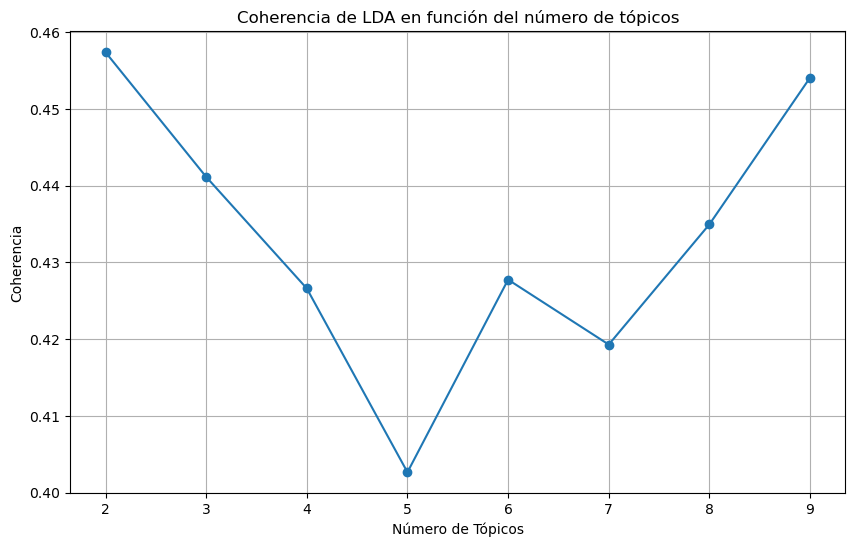

In [84]:
# Graficar la coherencia en función del número de tópicos
plt.figure(figsize=(10, 6))
plt.plot(num_topics_range, coherence_values, marker='o', linestyle='-')
plt.xlabel('Número de Tópicos')
plt.ylabel('Coherencia')
plt.title('Coherencia de LDA en función del número de tópicos')
plt.xticks(num_topics_range)
plt.grid()
plt.show()

### Ajuste de modelo LDA Gensim

In [134]:
# Entrenar el modelo LDA
num_topics = 2
lda_gensim_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=100)

In [135]:
# Ver los tópicos
for i, topic in enumerate(lda_gensim_model.print_topics(num_topics=num_topics, num_words=10)):
    print(f"Tópico {i}:")
    print(" ".join([word.split('*')[1].replace('"', '').strip() for word in topic[1].split('+')]))


Tópico 0:
ver amigo profe gráfico bitcoin decir hora comprar pasar listo
Tópico 1:
ver nivel objetivo fase precio semana bitcoin plazo llegar mercado


### Clusterización

In [136]:
# Aplicar K-means a los embeddings reducidos por t-SNE
kmeans = KMeans(n_clusters=2, n_init=10, random_state=0)
clusters = kmeans.fit_predict(embeddings_tsne)

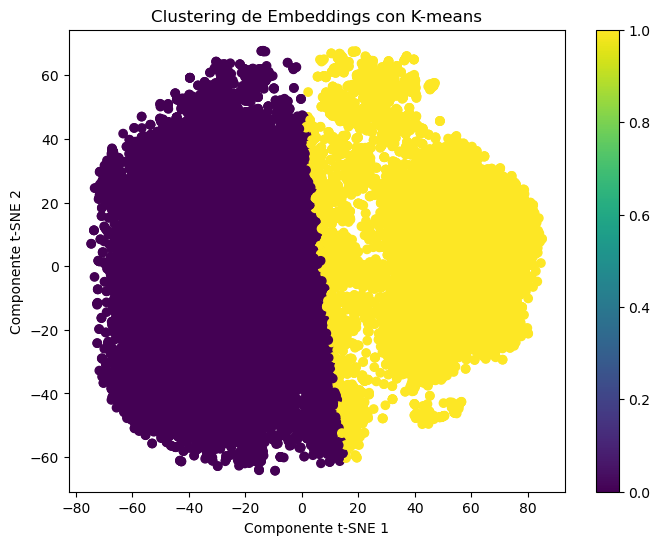

In [137]:
# Visualización de clusters
plt.figure(figsize=(8, 6))
plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], c=clusters, cmap='viridis')
plt.xlabel('Componente t-SNE 1')
plt.ylabel('Componente t-SNE 2')
plt.title('Clustering de Embeddings con K-means')
plt.colorbar()
plt.show()

### Análisis de tópicos

In [139]:
# Obtener las distribuciones de tópicos para cada documento
topic_distributions = [lda_gensim_model.get_document_topics(doc, minimum_probability=0) for doc in corpus]

# Extraer el tópico dominante para cada documento y encontrar el tópico con la mayor probabilidad
lda_topics = []
for doc_topics in topic_distributions:
    dominant_topic = max(doc_topics, key=lambda x: x[1])[0]
    lda_topics.append(dominant_topic)

In [140]:
# Añadir resultados de LDA y clustering al DataFrame original
df['lda_topic'] = lda_topics
df['cluster'] = clusters

In [141]:
# Evaluar la coherencia de tópicos dentro de cada cluster
topic_cluster_coherence = df.groupby(['cluster', 'lda_topic']).size().unstack(fill_value=0)
topic_cluster_coherence

lda_topic,0,1
cluster,,
0,15331,112
1,2025,8450


In [142]:
# Basado en la tabla de distribución, definir los tópicos predominantes por clúster
top_topics_per_cluster = {0: 0, 1: 1}

In [144]:
# Extraer las palabras clave para cada tópico predominante
final_topics = {}
for cluster, topic_idx in top_topics_per_cluster.items():
    top_features = [word for word, prob in lda_gensim_model.show_topic(topic_idx, topn=10)]
    final_topics[cluster] = top_features

In [145]:
# Mostrar los tópicos finales
for cluster, words in final_topics.items():
    print(f"Tópico principal para el clúster {cluster}: {', '.join(words)}")

Tópico principal para el clúster 0: ver, amigo, profe, gráfico, bitcoin, decir, hora, comprar, pasar, listo
Tópico principal para el clúster 1: ver, nivel, objetivo, fase, precio, semana, bitcoin, plazo, llegar, mercado


## Con ajuste de parámetros

### Calculo de coherencias

In [147]:
# Crear la matriz término-documento
vectorizer = CountVectorizer(tokenizer=lambda x: x, lowercase=False)
X = vectorizer.fit_transform(df['processed_text'])

In [148]:
feature_names = vectorizer.get_feature_names_out()

In [149]:
# Convertir documentos a listas de palabras
documents = df['processed_text']

# Crear el diccionario y el corpus
dictionary = Dictionary(documents)
corpus = [dictionary.doc2bow(doc) for doc in documents]

In [150]:
# Definir un rango de números de tópicos
num_topics_range = range(2, 10)
coherence_values = []

In [152]:
# Entrenar un modelo LDA para cada número de tópicos en el rango y calcular la coherencia
for num_topics in num_topics_range:
    lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=100,
                         chunksize=2000, passes=10, alpha='asymmetric', per_word_topics=True)
    coherence_model = CoherenceModel(model=lda_model, texts=documents, dictionary=dictionary, coherence='c_v')
    coherence_lda = coherence_model.get_coherence()
    coherence_values.append(coherence_lda)
    print(f'Número de tópicos: {num_topics}, Coherencia: {coherence_lda}')

Número de tópicos: 2, Coherencia: 0.4394779369463436
Número de tópicos: 3, Coherencia: 0.4363887915634676
Número de tópicos: 4, Coherencia: 0.447727747122194
Número de tópicos: 5, Coherencia: 0.45863655754529536
Número de tópicos: 6, Coherencia: 0.4613990054497057
Número de tópicos: 7, Coherencia: 0.4383202504158765
Número de tópicos: 8, Coherencia: 0.47338978398655407
Número de tópicos: 9, Coherencia: 0.47181572313109044


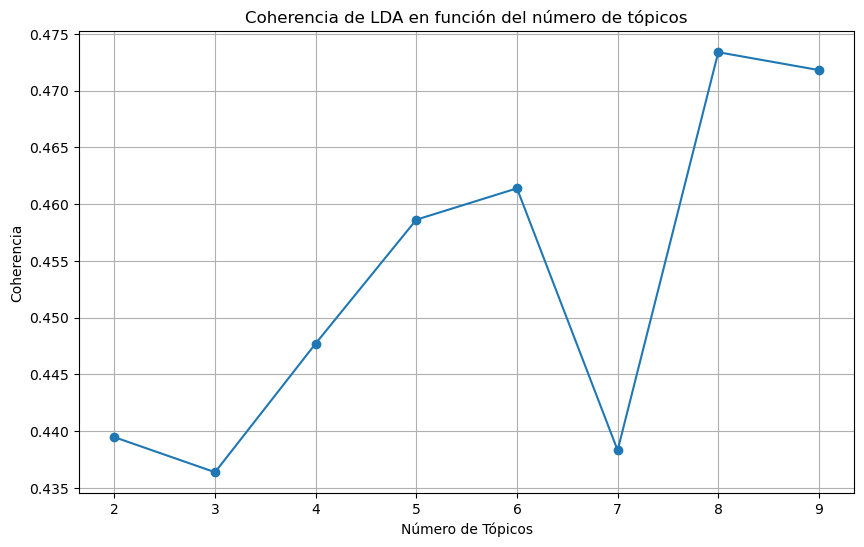

In [153]:
# Graficar la coherencia en función del número de tópicos
plt.figure(figsize=(10, 6))
plt.plot(num_topics_range, coherence_values, marker='o', linestyle='-')
plt.xlabel('Número de Tópicos')
plt.ylabel('Coherencia')
plt.title('Coherencia de LDA en función del número de tópicos')
plt.xticks(num_topics_range)
plt.grid()
plt.show()

### Ajuste de modelo LDA Gensim

In [175]:
# Entrenar el modelo LDA
num_topics = 8
lda_gensim_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=100, chunksize=3000, passes=25, alpha='asymmetric', per_word_topics=True)

In [176]:
coherence_model = CoherenceModel(model=lda_gensim_model, texts=documents, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model.get_coherence()
coherence_lda

0.4873625985451128

### Clusterización

In [177]:
# Aplicar K-means a los embeddings reducidos por t-SNE
kmeans = KMeans(n_clusters=8, n_init=10, random_state=0)
clusters = kmeans.fit_predict(embeddings_tsne)

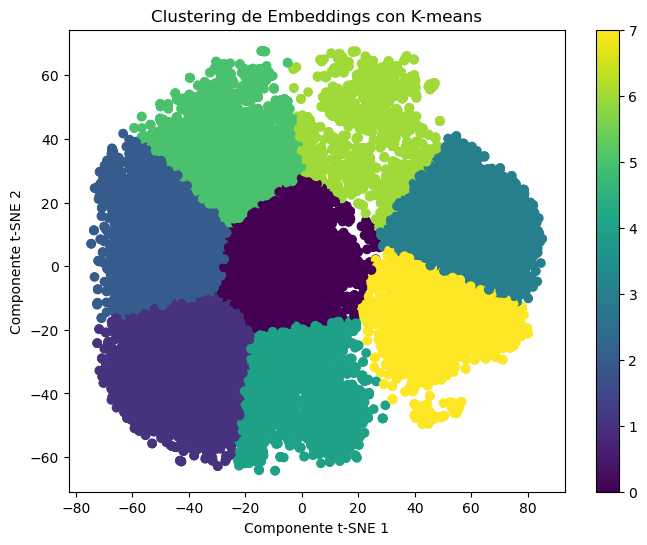

In [178]:
# Visualización de clusters
plt.figure(figsize=(8, 6))
plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], c=clusters, cmap='viridis')
plt.xlabel('Componente t-SNE 1')
plt.ylabel('Componente t-SNE 2')
plt.title('Clustering de Embeddings con K-means')
plt.colorbar()
plt.show()

### Análisis de tópicos

In [179]:
# Obtener las distribuciones de tópicos para cada documento
topic_distributions = [lda_gensim_model.get_document_topics(doc, minimum_probability=0) for doc in corpus]

# Extraer el tópico dominante para cada documento y encontrar el tópico con la mayor probabilidad
lda_topics = []
for doc_topics in topic_distributions:
    dominant_topic = max(doc_topics, key=lambda x: x[1])[0]
    lda_topics.append(dominant_topic)

In [180]:
# Añadir resultados de LDA y clustering al DataFrame original
df['lda_topic'] = lda_topics
df['cluster'] = clusters

In [181]:
# Evaluar la coherencia de tópicos dentro de cada cluster
topic_cluster_coherence = df.groupby(['cluster', 'lda_topic']).size().unstack(fill_value=0)
topic_cluster_coherence

lda_topic,0,1,2,3,5,6,7
cluster,,,,,,,
0,282,32,1606,320,26,1157,9
1,27,1,3271,123,0,577,0
2,26,0,1397,54,1,2011,0
3,4,2762,0,1,836,0,6
4,54,9,2060,454,2,265,1
5,381,16,259,69,3,2226,68
6,616,330,120,48,16,97,1061
7,62,1371,6,6,1782,1,6


In [182]:
# Basado en la tabla de distribución, definir los tópicos predominantes por clúster
top_topics_per_cluster = {0: 2, 1: 2, 2: 6, 3: 1, 4: 2, 5: 6, 6: 7, 7: 5}

In [183]:
# Extraer las palabras clave para cada tópico predominante
final_topics = {}
for cluster, topic_idx in top_topics_per_cluster.items():
    top_features = [word for word, prob in lda_gensim_model.show_topic(topic_idx, topn=10)]
    final_topics[cluster] = top_features

In [184]:
# Mostrar los tópicos finales
for cluster, words in final_topics.items():
    print(f"Tópico principal para el clúster {cluster}: {', '.join(words)}")

Tópico principal para el clúster 0: gráfico, hora, ver, amigo, abajo, 4, decir, diario, fuerza, okay
Tópico principal para el clúster 1: gráfico, hora, ver, amigo, abajo, 4, decir, diario, fuerza, okay
Tópico principal para el clúster 2: profe, ver, amigo, saludo, ganar, listo, like, decir, gracias, btc
Tópico principal para el clúster 3: ver, fase, nivel, objetivo, semana, plazo, serie, cerrar, bitcoin, hora
Tópico principal para el clúster 4: gráfico, hora, ver, amigo, abajo, 4, decir, diario, fuerza, okay
Tópico principal para el clúster 5: profe, ver, amigo, saludo, ganar, listo, like, decir, gracias, btc
Tópico principal para el clúster 6: acción, mercado, mirar, año, decir, empresa, colombia, subir, bolsa, dólar
Tópico principal para el clúster 7: precio, onda, zona, mil, ver, nivel, momento, máximo, gráfico, mínimo


## Con ajuste de parámetros y outliers

### Calculo de coherencias

In [7]:
# Crear la matriz término-documento
vectorizer = CountVectorizer(tokenizer=lambda x: x, lowercase=False)
X = vectorizer.fit_transform(df['processed_text'])

/opt/anaconda3/envs/py3_12/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [8]:
feature_names = vectorizer.get_feature_names_out()

In [9]:
# Contar las frecuencias de los términos
term_freqs = defaultdict(int)
for doc in df['processed_text']:
    for term in doc:
        term_freqs[term] += 1

In [10]:
# Ordenar los términos por frecuencia
sorted_term_freqs = sorted(term_freqs.items(), key=lambda x: x[1], reverse=True)

In [11]:
# Extraer solo las frecuencias
frequencies = [freq for term, freq in sorted_term_freqs]

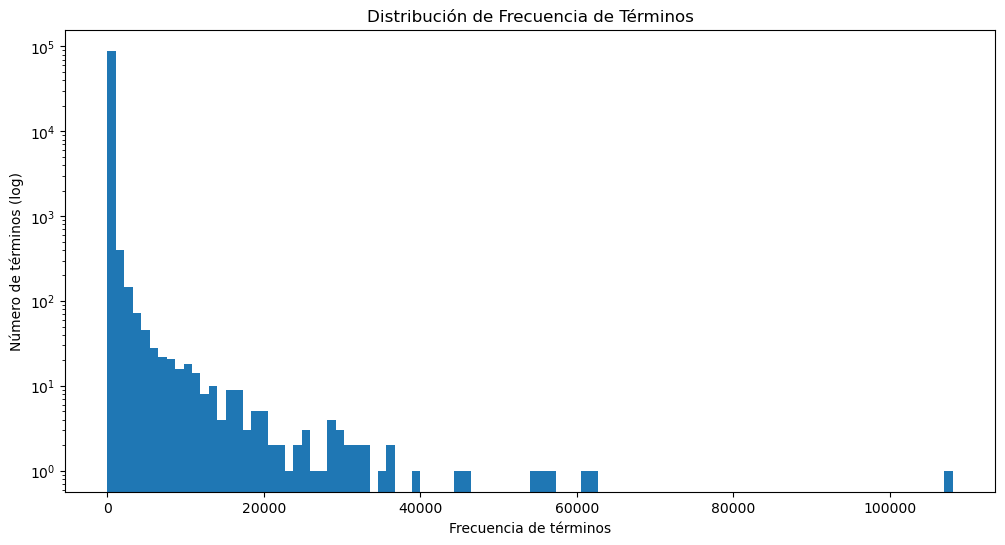

In [12]:
# Graficar la distribución de frecuencias
plt.figure(figsize=(12, 6))
plt.hist(frequencies, bins=100, log=True)
plt.xlabel('Frecuencia de términos')
plt.ylabel('Número de términos (log)')
plt.title('Distribución de Frecuencia de Términos')
plt.show()

In [13]:
# Definir parámetros recomendados
no_below = 500
no_above = 0.5

# Crear diccionario y corpus
documents = df['processed_text']
dictionary = corpora.Dictionary(documents)
dictionary.filter_extremes(no_below=no_below, no_above=no_above, keep_n=100000)
corpus = [dictionary.doc2bow(doc) for doc in documents]

In [3]:
# Definir un rango de números de tópicos
num_topics_range = range(2, 10)
coherence_values = []

In [15]:
# Entrenar un modelo LDA para cada número de tópicos en el rango y calcular la coherencia
for num_topics in num_topics_range:
    lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=100, chunksize=3000, passes=25, alpha='asymmetric', per_word_topics=True)
    coherence_model = CoherenceModel(model=lda_model, texts=documents, dictionary=dictionary, coherence='c_v')
    coherence_lda = coherence_model.get_coherence()
    coherence_values.append(coherence_lda)
    print(f'Número de tópicos: {num_topics}, Coherencia: {coherence_lda}')

Número de tópicos: 2, Coherencia: 0.5647345283262643
Número de tópicos: 3, Coherencia: 0.5463805254835707
Número de tópicos: 4, Coherencia: 0.5670934374438283
Número de tópicos: 5, Coherencia: 0.5650517328332145
Número de tópicos: 6, Coherencia: 0.5509710160738602
Número de tópicos: 7, Coherencia: 0.5533726330648374
Número de tópicos: 8, Coherencia: 0.5476958228396949
Número de tópicos: 9, Coherencia: 0.5736459990115512


### Ajuste de modelo LDA Gensim

In [16]:
# Entrenar el modelo LDA
num_topics = 9
lda_gensim_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=100, chunksize=3000, passes=25, alpha='asymmetric', per_word_topics=True)

In [17]:
coherence_model = CoherenceModel(model=lda_gensim_model, texts=documents, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model.get_coherence()
coherence_lda

0.5736459990115512

### Clusterización

In [27]:
# Aplicar K-means a los embeddings reducidos por t-SNE
kmeans = KMeans(n_clusters=9, n_init=200, random_state=0)
clusters = kmeans.fit_predict(embeddings_tsne)

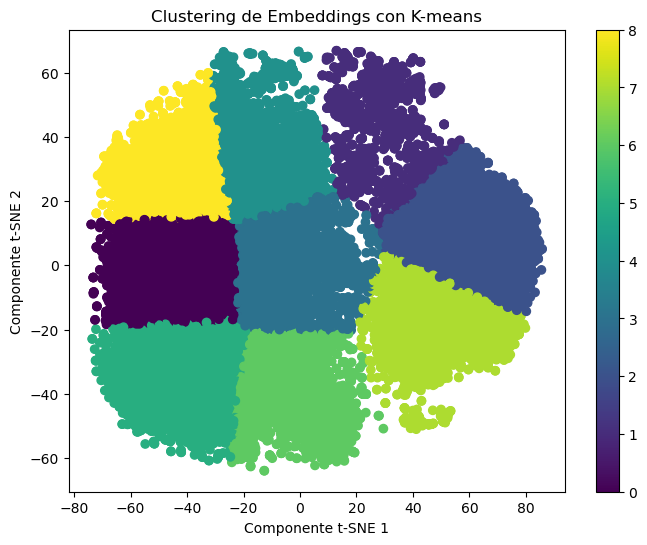

In [28]:
# Visualización de clusters
plt.figure(figsize=(8, 6))
plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], c=clusters, cmap='viridis')
plt.xlabel('Componente t-SNE 1')
plt.ylabel('Componente t-SNE 2')
plt.title('Clustering de Embeddings con K-means')
plt.colorbar()
plt.show()

### Análisis de tópicos

In [29]:
# Obtener las distribuciones de tópicos para cada documento
topic_distributions = [lda_gensim_model.get_document_topics(doc, minimum_probability=0) for doc in corpus]

# Extraer el tópico dominante para cada documento y encontrar el tópico con la mayor probabilidad
lda_topics = []
for doc_topics in topic_distributions:
    dominant_topic = max(doc_topics, key=lambda x: x[1])[0]
    lda_topics.append(dominant_topic)

In [30]:
# Añadir resultados de LDA y clustering al DataFrame original
df['lda_topic'] = lda_topics
df['cluster'] = clusters

In [31]:
# Evaluar la coherencia de tópicos dentro de cada cluster
topic_cluster_coherence = df.groupby(['cluster', 'lda_topic']).size().unstack(fill_value=0)
topic_cluster_coherence

lda_topic,0,1,2,3,4,5,6,7,8
cluster,,,,,,,,,
0,0,0,1311,1,2,48,924,6,737
1,24,114,83,2,186,19,18,1449,73
2,1602,1476,0,203,357,1,0,25,0
3,57,57,1099,57,26,381,340,135,853
4,11,8,1133,3,14,689,333,271,80
5,0,1,615,2,2,47,581,13,2117
6,4,0,416,39,19,124,299,23,1765
7,1521,234,8,695,574,5,1,46,4
8,0,0,1991,2,2,51,298,21,190


In [32]:
# Basado en la tabla de distribución, definir los tópicos predominantes por clúster
top_topics_per_cluster = {0: 7, 1: 8, 2: 0, 3: 2, 4: 2, 5: 1, 6: 2, 7: 8, 8: 2}

In [33]:
# Extraer las palabras clave para cada tópico predominante
final_topics = {}
for cluster, topic_idx in top_topics_per_cluster.items():
    top_features = [word for word, prob in lda_gensim_model.show_topic(topic_idx, topn=10)]
    final_topics[cluster] = top_features

In [34]:
# Mostrar los tópicos finales
for cluster, words in final_topics.items():
    print(f"Tópico principal para el clúster {cluster}: {', '.join(words)}")

Tópico principal para el clúster 0: acción, año, dinero, mundo, hablar, país, empresa, dólar, gente, invertir
Tópico principal para el clúster 1: diario, media, fuerza, 4, tendencia, okay, patrón, romper, punto, 200
Tópico principal para el clúster 2: nivel, cerrar, diario, semana, objetivo, zona, serie, plazo, ocurrir, escenario
Tópico principal para el clúster 3: profe, saludo, gracias, like, btc, listo, okay, greg, gracia, cripto
Tópico principal para el clúster 4: profe, saludo, gracias, like, btc, listo, okay, greg, gracia, cripto
Tópico principal para el clúster 5: fase, máximo, objetivo, plazo, valer, zona, mínimo, serie, liquidez, buscar
Tópico principal para el clúster 6: profe, saludo, gracias, like, btc, listo, okay, greg, gracia, cripto
Tópico principal para el clúster 7: diario, media, fuerza, 4, tendencia, okay, patrón, romper, punto, 200
Tópico principal para el clúster 8: profe, saludo, gracias, like, btc, listo, okay, greg, gracia, cripto


In [38]:
document_count_per_cluster = df['cluster'].value_counts().sort_index()
document_count_per_cluster

cluster
0    3029
1    1968
2    3664
3    3005
4    2542
5    3378
6    2689
7    3088
8    2555
Name: count, dtype: int64

# Análisis exploratorio

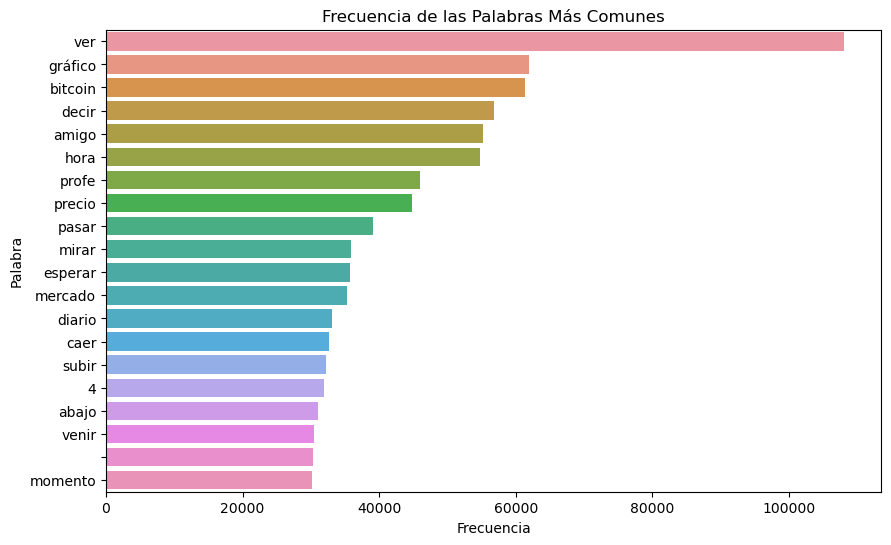

In [35]:
# Convertir listas de lemas a una sola lista de palabras
all_words = [word for tokens in df['processed_text'] for word in tokens]
freq_dist = FreqDist(all_words)
common_words = freq_dist.most_common(20)
df_common_words = pd.DataFrame(common_words, columns=['Palabra', 'Frecuencia'])
plt.figure(figsize=(10, 6))
sns.barplot(x='Frecuencia', y='Palabra', data=df_common_words)
plt.title('Frecuencia de las Palabras Más Comunes')
plt.show()

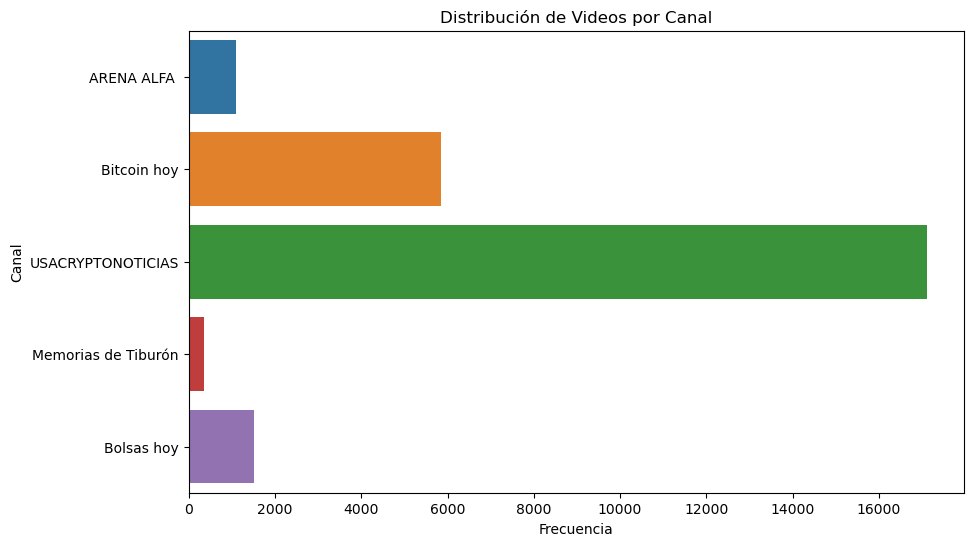

In [36]:
# Análisis de Canales
plt.figure(figsize=(10, 6))
sns.countplot(y='chanel_name', data=df)
plt.title('Distribución de Videos por Canal')
plt.xlabel('Frecuencia')
plt.ylabel('Canal')
plt.show()